In [101]:
import numpy as np
import pandas as pd

Dataset

In [102]:
df = pd.read_csv("apple_quality.csv")
df.head()


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


Calculates the number of unique values in each column

In [104]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

A_id: 4001 distinct values
Size: 4001 distinct values
Weight: 4001 distinct values
Sweetness: 4001 distinct values
Crunchiness: 4001 distinct values
Juiciness: 4001 distinct values
Ripeness: 4001 distinct values
Acidity: 4001 distinct values
Quality: 3 distinct values


Data Preprocessing 

In [105]:
def clean_data(df):
    
    df = df.drop(columns=['A_id'])
    df = df.dropna()
    df = df.astype({'Acidity': 'float64'})
    
    def label(Quality):
        if Quality == "good":
            return 0
        if Quality == "bad":
            return 1
        return None
    
    df['Label'] = df['Quality'].apply(label)
    df = df.drop(columns=['Quality'])
    df = df.astype({'Label': 'int64'})
    return df

df_clean = clean_data(df.copy())
df_clean.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Label
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,0
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,0
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,1
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,0
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,0


Histogram

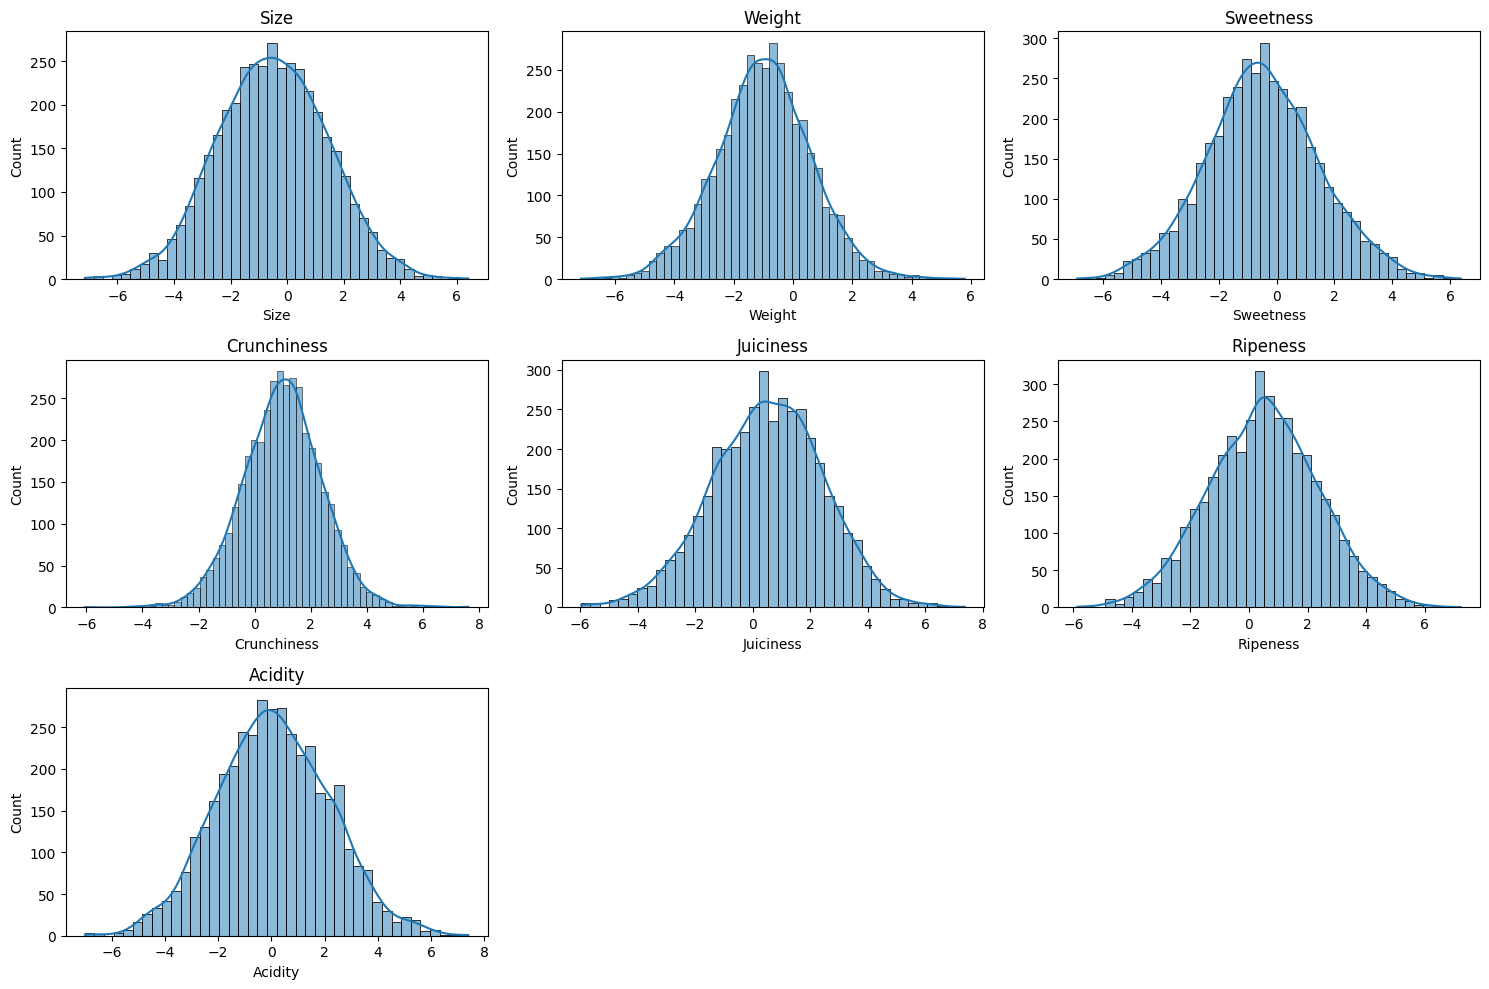

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']

plt.figure(figsize=(15, 10))
sns.set_palette("tab10")

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_clean, x=column, kde=True)  
    plt.title(column)

plt.tight_layout()
plt.show()

Correlation Heatmap

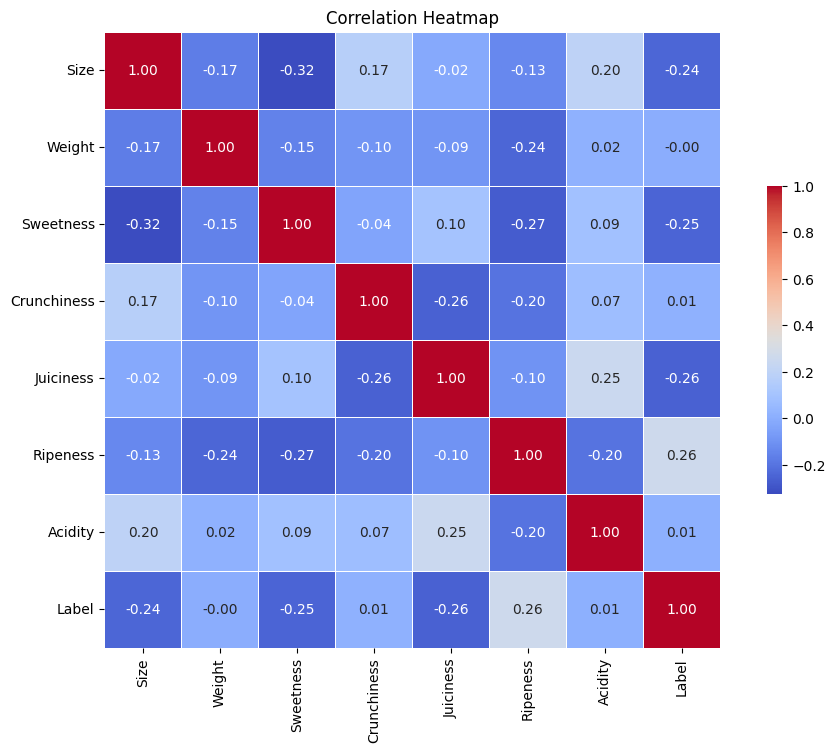

In [107]:
corr_matrix = df_clean.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap')
plt.show()

Split the Data

In [108]:
from sklearn.model_selection import train_test_split

X = df_clean.drop('Label', axis=1)  
y = df_clean['Label']             
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


PCA

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

# Initialize PCA and fit it to the scaled training data
pca = PCA(n_components=0.95)  # Keep 95% of variance
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Number of PCA components chosen:", pca.n_components_)


Number of PCA components chosen: 6


Modeling


Gradient Boosting Machines (GBM)

In [110]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(random_state=42)

gbm.fit(X_train_pca, y_train)

y_pred_gbm = gbm.predict(X_test_pca)

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluation for Gradient Boosting Machines (GBM)
gbm_mae = mean_absolute_error(y_test, y_pred_gbm)
gbm_mse = mean_squared_error(y_test, y_pred_gbm)
gbm_r2 = r2_score(y_test, y_pred_gbm)

print("\nMetrics for Gradient Boosting Machines (GBM):")
print("Mean Absolute Error:", gbm_mae)
print("Mean Squared Error:", gbm_mse)
print("R^2 Score:", gbm_r2)


Metrics for Gradient Boosting Machines (GBM):
Mean Absolute Error: 0.27862343516862126
Mean Squared Error: 0.1206319468972783
R^2 Score: 0.5174691965933653


Neural Networks (e.g., MLPRegressor)

In [111]:
from sklearn.neural_network import MLPRegressor

mlp_regressor = MLPRegressor(random_state=42)

mlp_regressor.fit(X_train_pca, y_train)

y_pred_mlp = mlp_regressor.predict(X_test_pca)

# Evaluation for Neural Networks
mlp_mae = mean_absolute_error(y_test, y_pred_mlp)
mlp_mse = mean_squared_error(y_test, y_pred_mlp)
mlp_r2 = r2_score(y_test, y_pred_mlp)

print("\nMetrics for Neural Networks (MLPRegressor):")
print("Mean Absolute Error:", mlp_mae)
print("Mean Squared Error:", mlp_mse)
print("R^2 Score:", mlp_r2)


Metrics for Neural Networks (MLPRegressor):
Mean Absolute Error: 0.23478537503344402
Mean Squared Error: 0.09691101913040495
R^2 Score: 0.6123535006877594


Random Forest

In [112]:
# Random Forests
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

random_forest.fit(X_train_pca, y_train)

y_pred_rf = random_forest.predict(X_test_pca)

# Evaluation for Random Forests
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print("\nMetrics for Random Forests:")
print("Mean Absolute Error:", rf_mae)
print("Mean Squared Error:", rf_mse)
print("R^2 Score:", rf_r2)


Metrics for Random Forests:
Mean Absolute Error: 0.2275875
Mean Squared Error: 0.10354912499999999
R^2 Score: 0.5858009112556952


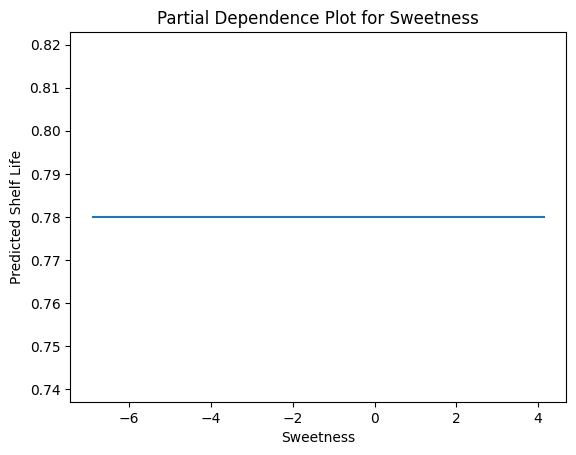

In [113]:
import numpy as np

def plot_pdp(model, X_train, feature_name):
    feature_values = np.linspace(np.percentile(X_train[feature_name], 0), np.percentile(X_train[feature_name], 99), 100)
    pred_shelf_life = []
    for value in feature_values:
        X_temp = X_train.copy()
        X_temp[feature_name] = value
        X_temp.drop(columns=[feature_name], inplace=True)  # Exclude the modified feature
        pred_shelf_life.append(model.predict(X_temp)[0])

    plt.plot(feature_values, pred_shelf_life)
    plt.xlabel(feature_name)
    plt.ylabel('Predicted Shelf Life')
    plt.title(f'Partial Dependence Plot for {feature_name}')
    plt.show()

# Plot PDP for the "Sweetness" feature
plot_pdp(random_forest, X_train, 'Sweetness')


Constant Predicted Shelf Life: The horizontal line suggests that, on average, changing the "Sweetness" feature from its lowest value to its highest value (i.e., from -6 to 4) doesn't have a significant impact on the predicted shelf life. This implies that the model doesn't consider "Sweetness" to be a strong predictor of shelf life within the observed range of values.

Limited Sweetness Range: The range of "Sweetness" values from -6 to 4 covers a relatively narrow spectrum. This could mean that the dataset has limited variability in "Sweetness" within this range, which might contribute to the observed constant predicted shelf life.

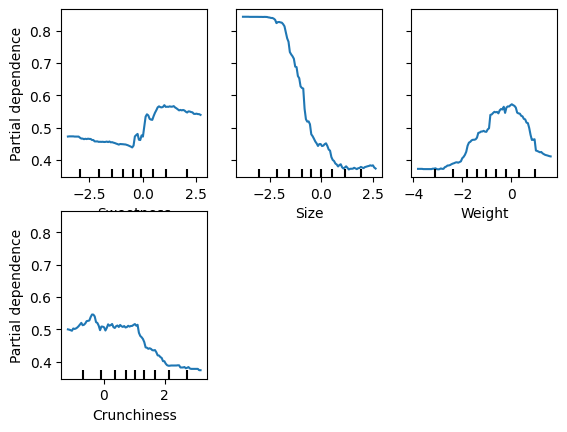

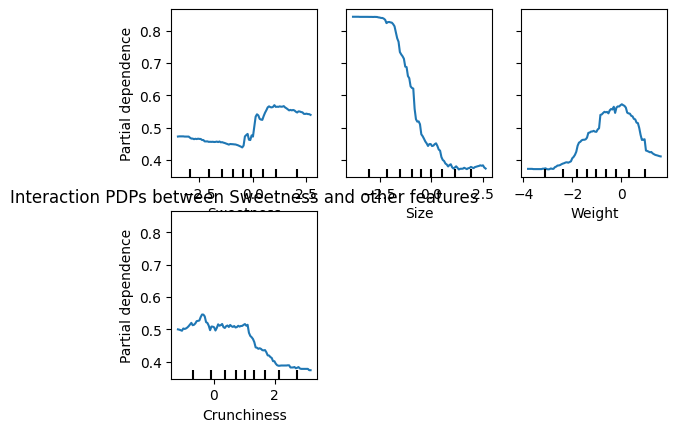

In [114]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Plot interaction PDPs between "Sweetness" and other features
def plot_interaction_pdp(model, X, feature_name, other_features):
    features_indices = [list(X.columns).index(feature_name)]
    for feature in other_features:
        features_indices.append(list(X.columns).index(feature))
    pdp_display = PartialDependenceDisplay.from_estimator(model, X, features_indices)
    pdp_display.plot()
    plt.title(f'Interaction PDPs between {feature_name} and other features')
    plt.show()

# Plot interaction PDPs between "Sweetness" and other features
other_features_to_interact = ['Size', 'Weight', 'Crunchiness']  # Adjust as needed
plot_interaction_pdp(random_forest, X_test, 'Sweetness', other_features_to_interact)

### Summary of Observations from Partial Dependence Plots (PDPs)

1. **Sweetness Partial Dependence Plot:**
   - The line starts at around (-3, 0.49) and remains relatively flat until around (0, 0.5), where it starts to increase gradually.
   - After reaching a peak around (2, 0.55), the line starts to decrease again towards (3, 0.5).
   - This indicates a non-linear relationship between sweetness and the predicted shelf life. Initially, increasing sweetness leads to a slight increase in predicted shelf life, reaching a peak, and then decreasing sweetness beyond a certain point leads to a decrease in predicted shelf life.

2. **Size Partial Dependence Plot:**
   - The line exhibits a stair-like pattern, decreasing from (-3, 0.8) to (3, 0.4) as the size increases from -3 to 3.
   - This suggests that larger sizes tend to have a lower predicted shelf life, with a more pronounced decrease beyond a certain threshold.

3. **Weight Partial Dependence Plot:**
   - The plot shows a ramp-like pattern, with the highest predicted shelf life occurring at a weight of (0, 0.55).
   - This indicates that as weight increases, there is generally an increase in predicted shelf life, with diminishing returns beyond a certain weight.

4. **Crunchiness Partial Dependence Plot:**
   - The line exhibits a slightly decreasing trend from (0, 0.5) to (3, 0.35).
   - This suggests that an increase in crunchiness initially leads to a slight decrease in predicted shelf life, with dimini    ching returns as crunchiness contiues to increase.
nues to increase.


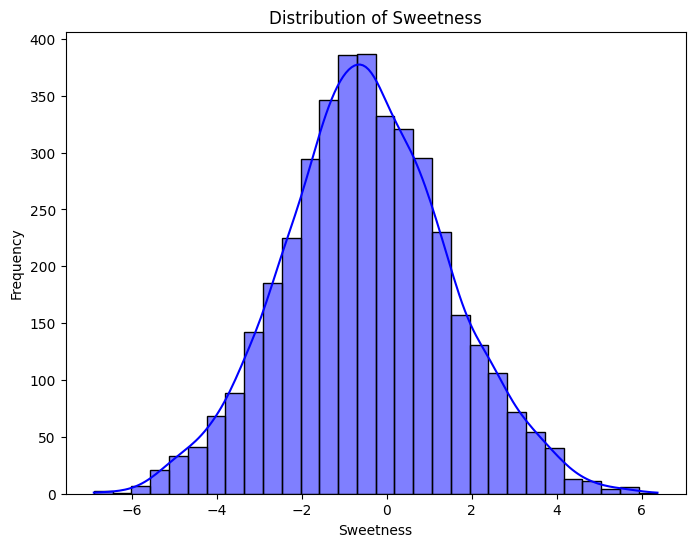

In [115]:
# Visualize the distribution of "Sweetness" values
plt.figure(figsize=(8, 6))
sns.histplot(df_clean['Sweetness'], kde=True, color='blue', bins=30)
plt.title('Distribution of Sweetness')
plt.xlabel('Sweetness')
plt.ylabel('Frequency')
plt.show()

In [116]:
from lime.lime_tabular import LimeTabularExplainer
from lime import lime_tabular
from sklearn.ensemble import RandomForestClassifier

# Convert the target labels to binary classification labels
y_train_binary = (y_train == 1)
y_test_binary = (y_test == 1)

# Train a Random Forest Classifier
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(X_train_pca, y_train_binary)

# Initialize the LIME explainer
explainer = LimeTabularExplainer(X_train_pca, feature_names=X.columns.tolist(), 
                                 discretize_continuous=False, mode="classification",
                                 verbose=True, class_names=['negative', 'positive'],
                                 feature_selection='auto', 
                                 discretizer='quartile',
                                 random_state=42)

# Explain an individual prediction
exp = explainer.explain_instance(X_test_pca[0], random_forest_classifier.predict_proba, num_features=len(X.columns))

# Plot the explanation
exp.show_in_notebook()

Intercept 0.5130670261631846
Prediction_local [0.43940326]
Right: 0.36


In [117]:
%%html
<style>
    .lime { background-color: #FFFFFF; color: #000000; }
</style>


### Analysis of LIME Results for Predicting Fruit Shelf Life

Based on the LIME explanation and the provided table, we can observe the following:

1. **Intercept and Prediction Probabilities**:
   - The intercept value indicates the base prediction made by the model, while the prediction probabilities suggest the likelihood of the predicted class. In this case, the model predicts a positive outcome with a probability of 0.36.

2. **Feature Importance**:
   - **Size**: The negative coefficient suggests that smaller sizes tend to contribute to a negative prediction (i.e., shorter shelf life).
   - **Juiciness**: A negative coefficient indicates that higher juiciness levels are associated with a negative prediction.
   - **Sweetness**: Positive coefficient implies that increased sweetness contributes positively to the prediction, suggesting a longer shelf life.
   - **Weight**: Higher weight is positively associated with longer shelf life, as indicated by the positive coefficient.
   - **Crunchiness**: Negative coefficient suggests that increased crunchiness leads to a shorter predicted shelf life.
   - **Ripeness**: The positive coefficient indicates that higher ripeness levels are associated with a longer shelf life.

3. **Relationship Analysis**:
   - **Size and Juiciness**: Smaller and juicier fruits are likely to have a shorter predicted shelf life, while larger and less juicy fruits tend to have a longer predicted shelf life.
   - **Sweetness and Weight**: Higher sweetness levels and heavier fruits are associated with a longer predicted shelf life, which aligns with common expectations.
   - **Crunchiness and Ripeness**: Interestingly, increased ripeness is associated with a longer predicted shelf life, while higher crunchiness is linked to a shorter predicted shelf life. This suggests a complex relationship between fruit texture and shelf life, where overly ripe fruits might have a longer shelf life despite being less crunchy.

Overall, the analysis suggests that sweetness, weight, and ripeness play crucial roles in predicting the shelf life of fruits. However, the relationship between certain factors (e.g., ripeness and crunchiness) may not be straightforward and requires further investigation.


 98%|===================| 782/800 [00:11<00:00]       

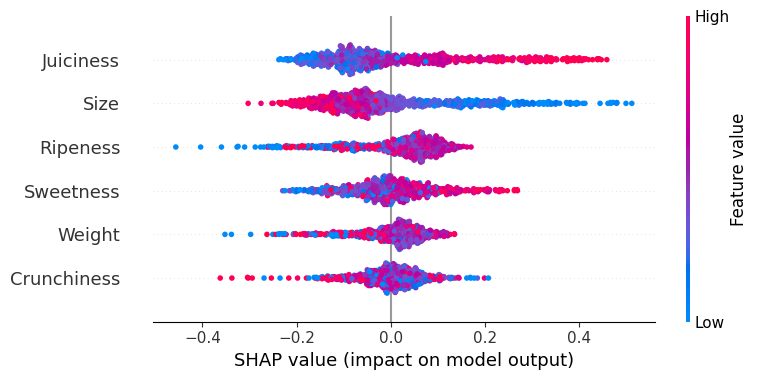

In [118]:
import shap

# Get the feature names
feature_names = X.columns

# Initialize the SHAP explainer
shap_explainer = shap.Explainer(random_forest, X_train_pca)

# Compute SHAP values
shap_values = shap_explainer.shap_values(X_test_pca)

# Plot SHAP summary plot with proper feature names
shap.summary_plot(shap_values, X_test_pca, feature_names=feature_names)

### Analysis of SHAP Summary Plot

1. **Juiciness:**
   - Majority of dots are on the left side of 0, indicating that lower values of juiciness tend to contribute negatively to the predicted shelf life. This suggests that fruits with lower juiciness are associated with shorter predicted shelf life.

2. **Size:**
   - Most dots are on the right side of 0, indicating that larger sizes tend to contribute positively to the predicted shelf life. This implies that larger fruits are expected to have a longer shelf life compared to smaller ones.

3. **Ripeness:**
   - Dots are predominantly on the right side of 0, indicating that higher ripeness levels contribute positively to the predicted shelf life. This suggests that riper fruits are expected to have a longer shelf life.

4. **Sweetness:**
   - Dots are concentrated around 0, with a mix of red and blue dots. Towards the left, there's a prevalence of blue dots, suggesting that lower sweetness levels contribute negatively to predicted shelf life. Conversely, towards the right, there's a prevalence of red dots, indicating that higher sweetness levels contribute positively to predicted shelf life. This suggests a non-linear relationship, where both too low and too high sweetness levels may have a negative impact on shelf life.

5. **Weight:**
   - Similar to ripeness, most dots are on the right side of 0, indicating that higher weights contribute positively to the predicted shelf life. This implies that heavier fruits are expected to have a longer shelf life.

6. **Crunchiness:**
   - Dots are spread across both sides of 0, indicating that the relationship between crunchiness and predicted shelf life is more nuanced. Towards the left, there's a prevalence of blue dots, suggesting that lower crunchiness levels contribute negatively to predicted shelf life. Towards the right, there's a mix of red and blue dots, indicating a less clear relationship compared to other features.

Overall, these observations suggest that larger, riper, sweeter, and heavier fruits tend to have longer predicted shelf lives, while lower levels of juiciness and crunchiness may negatively impact shelf life. Additionally, the relationship between sweetness and crunchiness appears to be more complex, with both low and high levels potentially impacting shelf life negatively.
